# Resolução checkpoint 3 - sem. 2

## Módulos

In [1]:
# gerais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# teste de hipóteses
from scipy import stats as st

## Dados

In [3]:
dados_atendimentos = pd.read_csv('dados_atendimentos.csv')

In [4]:
dados_atendimentos.head()

,idEntrada,state,usuarioOnline,statusSaida,paginaSaida,avaliacao,dataHoraEntrada,dataHoraSaida,dataHoraErro,tempoAcesso,codigo,erro
0,1,CE,1,80%,1,positiva,18/05/2021 17:57,18/05/2021 18:00,18/05/2021 17:59,173,550,"""NO MOMENTO ESTE SERIVCO ESTA INDISPONIVEL. PO..."
1,2,PE,0,40%,3,negativa,18/05/2021 17:57,18/05/2021 18:01,18/05/2021 18:00,212,550,"""ERRO NA VALIDACAO DE DADOS COMPLEMENTARES"""
2,3,CE,0,60%,2,negativa,18/05/2021 17:57,18/05/2021 18:04,18/05/2021 18:03,427,500,"""INTERNAL SERVER ERROR"""
3,4,PR,0,20%,4,negativa,18/05/2021 17:57,18/05/2021 18:01,18/05/2021 18:00,248,550,"""CPF -CNPJ CLIENTE NAO CADASTRADO"""
4,5,TO,0,20%,4,positiva,18/05/2021 17:57,18/05/2021 18:01,18/05/2021 18:02,256,500,"""OPS! NÃO FOI POSSIVEL CONSULTAR O SALDO. TENT..."


In [5]:
dados_renda = pd.read_csv('dados_renda_municipios_2010.csv')

In [6]:
dados_renda.head()

,state,city,RDPC
0,GO,Abadia de Goiás/GO,574.96
1,MG,Abadia dos Dourados/MG,596.18
2,GO,Abadiânia/GO,519.87
3,PA,Abaetetuba/PA,293.01
4,MG,Abaeté/MG,707.24


## Funções

- Índice de Gini

Utilizar esta função para calcular o índice de gini para cada estado.

In [7]:
def gini(array: np.ndarray or pd.core.series.Series) -> float:
    """
    Calculates the Gini coefficient of a 1D array.

    Args:
        array (array-like): A 1D array of values.

    Returns:
        float: The Gini coefficient of the array.

    """
    # Convert a pandas series to a numpy array
    if type(array) == pd.core.series.Series:
        array = array.to_numpy()

    # Flatten the array if it is not already 1D
    array = array.flatten()

    # Convert the array to float64 if it is not already
    if array.dtype != np.float64:
        array = np.ascontiguousarray(array, dtype=np.float64)

    # Shift the values in the array so that the minimum value is 0
    if np.amin(array) < 0:
        array -= np.amin(array)

    array += 0.0000001
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))

## Questões

#### 1 - Na tabela do censo de 2010, obter o índice de Gini por UF (state) (criar um dataframe como df_gini_estado) e realizar o join das tabelas de atendimento e df_gini_estado.

In [8]:
df_gini_estado = dados_renda.groupby('state')['RDPC'] \
                            .apply(lambda x: gini(x.values)) \
                            .to_frame('GINI') \
                            .reset_index() \
                            .sort_values('GINI')

df_gini_estado.head()

,state,GINI
6,DF,0.000000
20,RO,0.127922
17,PR,0.131235
5,CE,0.132551
14,PB,0.134084


#### 2 – Realizar o teste t para os itens abaixo:

##### a) Avaliação (Positiva e Negativa) e Tempo de Acesso.

In [9]:
avaliacoes_positivas = dados_atendimentos[dados_atendimentos['avaliacao'] == 'positiva']
avaliacoes_negativas = dados_atendimentos[dados_atendimentos['avaliacao'] == 'negativa']
avaliacoes_positivas_tempo_acesso = avaliacoes_positivas['tempoAcesso']
avaliacoes_negativas_tempo_acesso = avaliacoes_negativas['tempoAcesso']

In [26]:
estatistica_t, valor_p = st.ttest_ind(avaliacoes_positivas_tempo_acesso, avaliacoes_negativas_tempo_acesso, alternative='two-sided')
estatistica_t, valor_p

(0.6970955841932512, 0.48595643103026165)

##### b) Avaliação (Positiva e Negativa) e GINI.

In [27]:
avaliacoes_positivas_gini = avaliacoes_positivas.merge(df_gini_estado, right_on='state', left_on = 'state')
avaliacoes_positivas_gini = avaliacoes_positivas_gini['GINI']
avaliacoes_negativas_gini = avaliacoes_negativas.merge(df_gini_estado, right_on='state', left_on = 'state')
avaliacoes_negativas_gini = avaliacoes_negativas_gini['GINI']

estatistica_t2, valor_p2 = st.ttest_ind(avaliacoes_positivas_gini, avaliacoes_negativas_gini, alternative='two-sided')
estatistica_t2, valor_p2

(-0.17533257796805335, 0.8608650776872567)

#### 3 – Realizar o teste F para os itens abaixo:

In [28]:
def f_p_value(f_valor, df_n, df_d, test_type):
  
  '''test_type: greater, less, two.sided'''
  
  if test_type == 'greater':
    return 1 - st.f.cdf(f_valor, df_n, df_d)
  elif test_type == 'less':
    return st.f.cdf(f_valor, df_n, df_d)
  elif test_type == 'two.sided':
    p1 = st.f.cdf(f_valor, df_n, df_d)
    p2 = 1 - st.f.cdf(f_valor, df_n, df_d)
    return np.min([p1, p2])*2
  else:
    raise TypeError("'test_type' only accept options: 'greater', 'less' or 'two.sided'")

##### a) Avaliação e Tempo de Acesso.

In [29]:
f_valor = np.var(avaliacoes_positivas_tempo_acesso, ddof=1) / np.var(avaliacoes_negativas_tempo_acesso, ddof=1)

p = f_p_value(f_valor, len(avaliacoes_positivas_tempo_acesso)-1, len(avaliacoes_negativas_tempo_acesso)-1, 'two.sided')
f_valor, p

(0.8976651487841281, 0.3325025990054121)

##### b) Avaliação e GINI.

In [15]:
f_valor2 = np.var(avaliacoes_positivas_gini, ddof=1) / np.var(avaliacoes_negativas_gini, ddof=1)

p2 = f_p_value(f_valor2, len(avaliacoes_positivas_gini)-1, len(avaliacoes_negativas_gini)-1, 'two.sided')
f_valor2, p2

(0.9659067966010344, 0.7608905704855919)

#### 4 – Realizar o teste de Qui-Quadrado para:

##### a) Avaliação e código de erro (utilizando somente positivos e negativos)

In [32]:
avaliacoes_positivas_codigo = avaliacoes_positivas['codigo']
avaliacoes_negativas_codigo = avaliacoes_negativas['codigo']
avaliacoes_codigo = pd.concat([avaliacoes_positivas_codigo, avaliacoes_negativas_codigo], axis=0)
*st.chisquare(avaliacoes_codigo.value_counts()),

(0.8212877792378449, 0.36480391833678083)

##### b) Avaliação e código de erro (utilizando positivos, negativos e não avaliado)

In [33]:
avaliacoes_codigo_todas = dados_atendimentos['codigo']
avaliacoes_codigo_todas = avaliacoes_codigo_todas.value_counts()
*st.chisquare(avaliacoes_codigo_todas),

(4.356, 0.03687880184110112)

#### 5 – Obter a correlação entre Gini e Tempo de acesso. A correlação é fraca, moderada ou forte?

Correlação fraca.

In [21]:
avaliacoes_positivas_gini_tempo = avaliacoes_positivas.merge(df_gini_estado, right_on='state', left_on = 'state')
avaliacoes_positivas_gini_tempo = avaliacoes_positivas_gini_tempo[['GINI', 'tempoAcesso']]
avaliacoes_positivas_gini_tempo = avaliacoes_positivas_gini_tempo.dropna()
correlacao = avaliacoes_positivas_gini_tempo.corr()
correlacao

,GINI,tempoAcesso
GINI,1.000000,0.089508
tempoAcesso,0.089508,1.000000


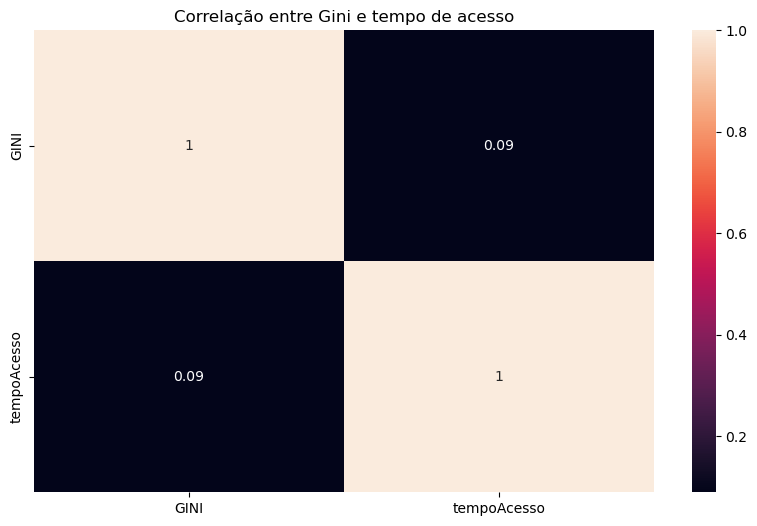

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(correlacao, annot=True, ax=ax)
ax.set_title('Correlação entre Gini e tempo de acesso')
plt.show()